In [466]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.stats import uniform

### Data Preprocessing

In [467]:
df = pd.read_csv('../flight-delay-dataset.csv')

In [468]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28820 entries, 0 to 28819
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   MONTH              28820 non-null  int64  
 1   DAY_OF_MONTH       28820 non-null  int64  
 2   DAY_OF_WEEK        28820 non-null  int64  
 3   OP_UNIQUE_CARRIER  28820 non-null  object 
 4   TAIL_NUM           28820 non-null  object 
 5   DEST               28820 non-null  object 
 6   DEP_DELAY          28820 non-null  int64  
 7   CRS_ELAPSED_TIME   28820 non-null  int64  
 8   DISTANCE           28820 non-null  int64  
 9   CRS_DEP_M          28820 non-null  int64  
 10  DEP_TIME_M         28820 non-null  int64  
 11  CRS_ARR_M          28820 non-null  int64  
 12  Temperature        28820 non-null  int64  
 13  Dew Point          28820 non-null  object 
 14  Humidity           28820 non-null  int64  
 15  Wind               28818 non-null  object 
 16  Wind Speed         288

In [469]:
# Remove NAs
df.isna().sum()
df.dropna(inplace=True)

In [470]:
# No duplicates
df.duplicated().value_counts()

False    28818
Name: count, dtype: int64

In [471]:
# Remove TAIL_NUM and TAXI_OUT
df.drop(columns=['TAIL_NUM', 'TAXI_OUT', 'DEP_TIME_M'], inplace=True)

In [472]:
# Convert DEW_POINT to int
df['Dew Point'] = df['Dew Point'].astype(int)

In [473]:
# Encode categorical variables
columns_to_encode = ['OP_UNIQUE_CARRIER', 'DEST', 'Wind', 'Condition']
df_encoded = pd.get_dummies(df, columns=columns_to_encode)

In [474]:
# Remove all values beyond 3 standard deviations from the mean
mean_dep_delay = df_encoded['DEP_DELAY'].mean()
std_dep_delay = df_encoded['DEP_DELAY'].std()
upper_threshold = mean_dep_delay + (3 * std_dep_delay)
df_encoded = df_encoded[df_encoded['DEP_DELAY'] <= upper_threshold]

# # Remove all values beyond 3*IQR
# Q1 = df_encoded['DEP_DELAY'].quantile(0.25)
# Q3 = df_encoded['DEP_DELAY'].quantile(0.75)
# IQR = Q3 - Q1
# lower_threshold = Q1 - (3 * IQR)
# upper_threshold = Q3 + (3 * IQR)
# df_encoded = df_encoded[df_encoded['DEP_DELAY'] <= upper_threshold]
# df_encoded = df_encoded[df_encoded['DEP_DELAY'] >= lower_threshold]


# Remove all values below 0
df_encoded = df_encoded[df_encoded['DEP_DELAY'] >= 15]

### Train/Test Split

In [475]:
# Split 80/20 train-test
X = df_encoded.drop(columns=['DEP_DELAY'])
y = df_encoded['DEP_DELAY']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Develop and Fit Model

In [476]:
# Find MSE if you were to predict all with the average
y_mean = y_train.mean()
y_train_pred_mean = np.full(y_train.shape, y_mean)
y_test_pred_mean = np.full(y_test.shape, y_mean)
mse_train_mean = mean_squared_error(y_train, y_train_pred_mean)
mse_test_mean = mean_squared_error(y_test, y_test_pred_mean)
mae_train_mean = mean_absolute_error(y_train, y_train_pred_mean)
mae_test_mean = mean_absolute_error(y_test, y_test_pred_mean)
print(f'Mean MSE Train: {mse_train_mean}, Mean MSE Test: {mse_test_mean}')
print(f'Mean MAE Train: {mae_train_mean}, Mean MAE Test: {mae_test_mean}')

Mean MSE Train: 736.7754516126444, Mean MSE Test: 726.0180249932113
Mean MAE Train: 22.05603126579942, Mean MAE Test: 22.20996029186083


In [477]:
xgb_reg = XGBRegressor(objective='reg:squarederror', random_state=42)

xgb_reg.fit(X_train, y_train)

y_pred = xgb_reg.predict(X_test)

# Calculate MSE
mse = mean_squared_error(y_test, y_pred)
print("MSE:", mse)

# Calculate MAE
mae = mean_absolute_error(y_test, y_pred)
print("MAE:", mae)

MSE: 532.0187439914763
MAE: 17.995675320672518


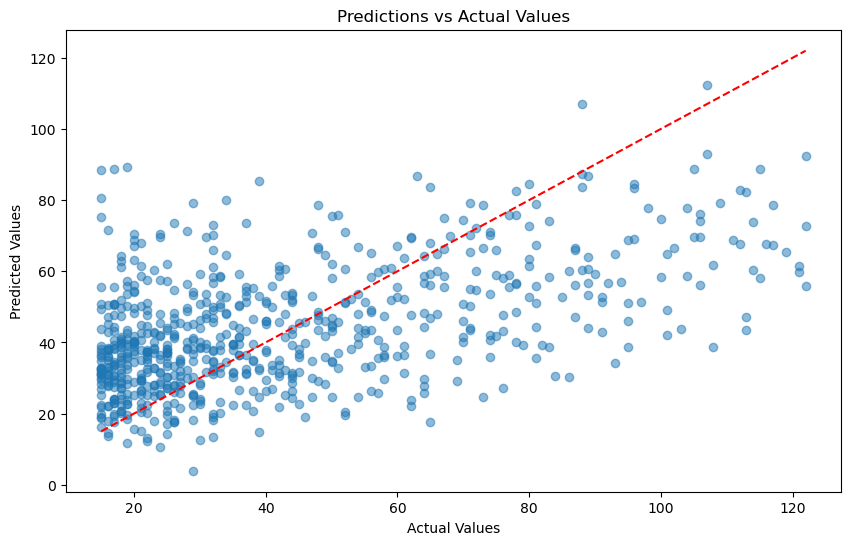

In [478]:
# Plot predictions vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Predictions vs Actual Values")
plt.show()

### Feature Selection

In [479]:
# Get feature importance
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': xgb_reg.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Display feature importance
print(feature_importance)

                          Feature  Importance
5                       CRS_DEP_M    0.034980
14                        sch_arr    0.030887
34                       DEST_CHS    0.024922
13                        sch_dep    0.023752
38                       DEST_CVG    0.021432
..                            ...         ...
113         Condition_Fog / Windy    0.000000
62                       DEST_ORH    0.000000
109     Condition_Drizzle and Fog    0.000000
65                       DEST_PHL    0.000000
131  Condition_Wintry Mix / Windy    0.000000

[132 rows x 2 columns]


In [480]:
# Set threshold
threshold = 0.01

# Select important features
selected_features = feature_importance[feature_importance["Importance"] > threshold]["Feature"].tolist()

print("Selected Features:", selected_features)

# Filter dataset
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

Selected Features: ['CRS_DEP_M', 'sch_arr', 'DEST_CHS', 'sch_dep', 'DEST_CVG', 'DEST_BQN', 'OP_UNIQUE_CARRIER_MQ', 'DEST_SLC', 'DEST_SJU', 'Wind_N', 'CRS_ARR_M', 'DEST_BUR', 'Condition_Partly Cloudy / Windy', 'Wind_E', 'Wind_SW', 'Wind_ESE', 'Condition_Cloudy', 'OP_UNIQUE_CARRIER_DL', 'Condition_Fair / Windy', 'OP_UNIQUE_CARRIER_OO', 'Wind Gust', 'DEST_SAV', 'Wind_W', 'OP_UNIQUE_CARRIER_B6', 'DEST_DEN', 'DEST_PDX', 'Wind_NW', 'DEST_PHX', 'Condition_Fair', 'DEST_SAN', 'DEST_CMH', 'DEST_CLT', 'DISTANCE', 'OP_UNIQUE_CARRIER_9E', 'DEST_MSP', 'Wind_WNW']


In [481]:
# Retrain XGBoost on filtered features
xgb_reg_selected = XGBRegressor(objective="reg:squarederror", random_state=42)
xgb_reg_selected.fit(X_train_selected, y_train)

# Evaluate new model
y_pred_selected = xgb_reg_selected.predict(X_test_selected)

mse_selected = mean_squared_error(y_test, y_pred_selected)

print("MSE (Selected Features):", mse_selected)

MSE (Selected Features): 445.1413585136508


### Hyperparameter Tuning

In [482]:
params = {
    'max_depth': [3, 5, 7, 10, 15],
    'n_estimators': [100, 150, 200, 250],
    'learning_rate': uniform(0.01, 0.3),
    'subsample': uniform(0.7, 0.3),
    'colsample_bytree': uniform(0.6, 0.4),
    'gamma': [0, 0.1, 0.2],
    'min_child_weight': [1, 5, 10]
}

# RandomizedSearchCV with 100 iterations
random_search_threshold = RandomizedSearchCV(XGBRegressor(objective='reg:squarederror', random_state=42),
                                   param_distributions=params, n_iter=100, scoring='neg_mean_absolute_error',
                                   cv=3, verbose=2, n_jobs=-1, random_state=42)
random_search_threshold.fit(X_train_selected, y_train)

print("Best Parameters:", random_search_threshold.best_params_)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Best Parameters: {'colsample_bytree': 0.9928673373317742, 'gamma': 0, 'learning_rate': 0.0825556872701355, 'max_depth': 10, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9647909029568018}


### Performance Evaluation

In [484]:
xgb_reg_best = random_search_threshold.best_estimator_
y_pred_best = xgb_reg_best.predict(X_test_selected)

# Calculate mean squared error
print('Best MSE:', mean_squared_error(y_test, y_pred_best))

# Calculate mean absolute error
print('Best MAE:', mean_absolute_error(y_test, y_pred_best))

Best MSE: 419.8191292722855
Best MAE: 15.799073652297132


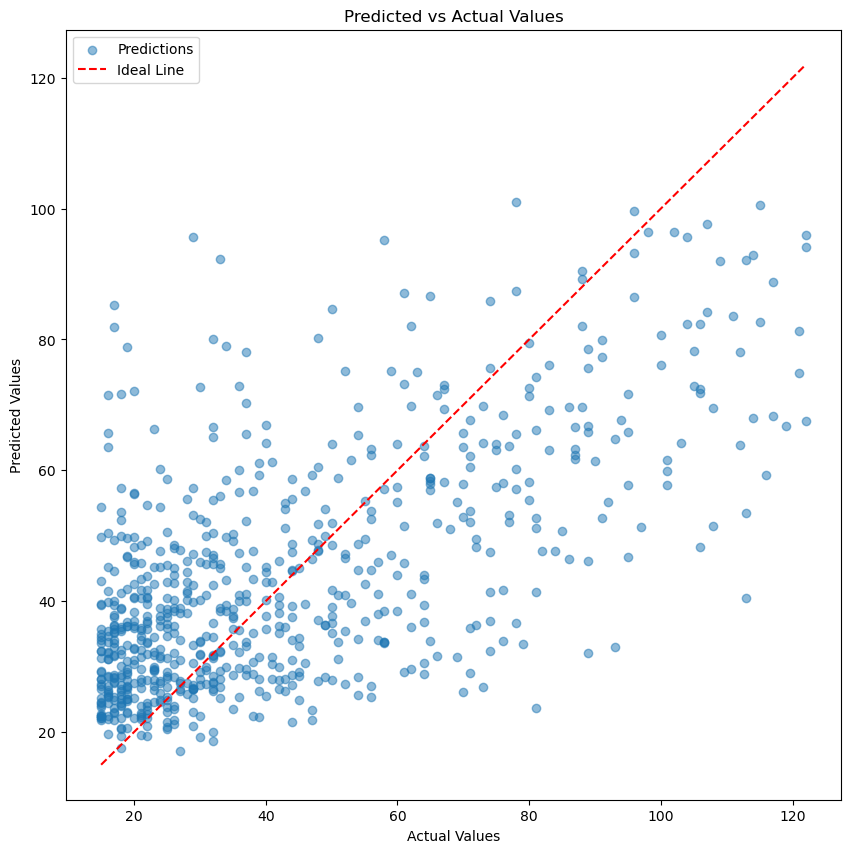

In [485]:
plt.figure(figsize=(10, 10))
plt.scatter(y_test, y_pred_best, alpha=0.5, label='Predictions')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Ideal Line')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs Actual Values')
plt.legend()
plt.show()